In [1]:
%reload_ext autoreload
%autoreload 2

from glob import glob
import numpy as np
import scipy
from scipy.interpolate import CubicSpline
#from scipy import integrate
import matplotlib.pyplot as plt
import sys
sys.path.append("../../../../dqmc_edit/thermaltest/Determinant-QMC/util/")
import util
import maxent
import matplotlib.ticker as ticker
plt.rcParams["figure.facecolor"] = 'w'
plt.rcParams.update({'font.size': 16, 'font.sans-serif':'Liberation Sans'})

from IPython.display import display_html
display_html("""<button onclick="$('.input, .output_stderr, .output_error').toggle();">Toggle Code</button>""", raw=True)

Toggle Code

In [2]:
def loading(U,tp,sitex,sitey,prefix):
    jeje = np.load("../calculation/"+prefix+f"jejeU{U:g}tp{tp:g}_{sitex:g}*{sitey:g}.npy")
    jkjk = np.load("../calculation/"+prefix+f"jkjkU{U:g}tp{tp:g}_{sitex:g}*{sitey:g}.npy")
    jpjp = np.load("../calculation/"+prefix+f"jpjpU{U:g}tp{tp:g}_{sitex:g}*{sitey:g}.npy")
    j0j0 = np.load("../calculation/"+prefix+f"j0j0U{U:g}tp{tp:g}_{sitex:g}*{sitey:g}.npy")
    C = np.load("../calculation/"+prefix+f"CU{U:g}tp{tp:g}_{sitex:g}*{sitey:g}.npy")
    chi = np.load("../calculation/"+prefix+f"chiU{U:g}tp{tp:g}_{sitex:g}*{sitey:g}.npy")
    
    jejes = np.load("../calculation/"+prefix+f"jejesU{U:g}tp{tp:g}_{sitex:g}*{sitey:g}.npy")
    jkjks = np.load("../calculation/"+prefix+f"jkjksU{U:g}tp{tp:g}_{sitex:g}*{sitey:g}.npy")
    jpjps = np.load("../calculation/"+prefix+f"jpjpsU{U:g}tp{tp:g}_{sitex:g}*{sitey:g}.npy")
    j0j0s = np.load("../calculation/"+prefix+f"j0j0sU{U:g}tp{tp:g}_{sitex:g}*{sitey:g}.npy")
    Cs = np.load("../calculation/"+prefix+f"CsU{U:g}tp{tp:g}_{sitex:g}*{sitey:g}.npy")
    chis = np.load("../calculation/"+prefix+f"chisU{U:g}tp{tp:g}_{sitex:g}*{sitey:g}.npy")
    
    
    return jeje ,jkjk,jpjp,j0j0,C,chi,jejes,jkjks,jpjps,j0j0s,Cs,chis


def calc(betas,U,tp,sitex,sitey,prefix = "transport_"):
    w = np.load(f"../calculation/wU={U:g}.npy")
    Ajeje ,Ajkjk,Ajpjp,Aj0j0,C,chi,jejes,jkjks,jpjps,j0j0s,Cs,chis = \
    loading(U,tp,sitex,sitey,prefix)
    
    Ls = np.zeros((len(betas), 2))
    kappas = np.zeros((len(betas),2))
    
    L1s = np.zeros((len(betas),2))
    kappa1s = np.zeros((len(betas),2))
    
    L2s = np.zeros((len(betas),2))
    kappa2s = np.zeros((len(betas),2))
    
    sigmas = np.zeros((len(betas),2))
    
    Ds = np.zeros((len(betas), 2))
    DQs = np.zeros((len(betas), 2))

    for j,beta in enumerate(betas[:]):
        jeje ,jkjk,jpjp,j0j0, = \
        jejes[0,j] ,jkjks[0,j],jpjps[0,j],j0j0s[0,j],


        ls =( jeje[:,0])/j0j0[:,0]*beta**2
        Ls[ j,1] = np.std(ls[:],ddof = 1)


        ks =( jeje[:,0])*beta


        kappas[ j,1] = np.std(ks[:],ddof = 1)


        ds = j0j0[:,0]/chis[0,j]
        dqs = ks/Cs[0,j]

        Ds[ j,1] = np.std(ds[:],ddof = 1)
        DQs[ j,1] = np.std(dqs[:],ddof = 1)


        kappa1sspart1 = ( jkjk[:,0])*beta
        kappa2sspart1  = ( jpjp[:,0])*beta

        part2 = (ks-kappa1sspart1-kappa2sspart1)/2

        l1s =( kappa1sspart1 + part2)/j0j0[:,0]*beta
        l2s =( kappa2sspart1 + part2)/j0j0[:,0]*beta


        L1s[ j,1]= np.std(l1s[:],ddof = 1)
        L2s[ j,1]= np.std(l2s[:],ddof = 1)
        kappa1s[ j,1] = np.std(kappa1sspart1+part2,ddof = 1)
        kappa2s[ j,1] = np.std(kappa2sspart1+part2,ddof = 1)
        sigmas[ j,1] = np.std(j0j0[:,0],ddof = 1)

        #########################################

        jeje ,jkjk,jpjp,j0j0 = \
        Ajeje[0,j],Ajkjk[0,j],Ajpjp[0,j],Aj0j0[0,j]



        Ls[ j,0]= ( jeje[0])/j0j0[0]*beta**2
        kappas[ j,0] =  (jeje[0])*beta

        kappa1spart1 = ( jkjk[0]) *beta
        kappa2spart1 = ( jpjp[0]) *beta

        part2= (kappas[ j,0] - kappa1spart1 - kappa2spart1 )/2

        kappa1s[ j,0] = kappa1spart1+part2
        kappa2s[ j,0] = kappa2spart1+part2

        L1s[ j,0]= ( kappa1s[ j,0] )/j0j0[0]*beta
        L2s[ j,0]= ( kappa2s[ j,0] )/j0j0[0]*beta
        sigmas[ j,0] = j0j0[0]

        Ds[ j,0] = sigmas[ j,0]/chi[0,j]
        DQs[ j,0] = kappas[ j,0]/C[0,j]


            
    return Ls,kappas,L1s,kappa1s,L2s ,kappa2s,sigmas,Ds,DQs

def derivative(xs,ys,yserror):
    newxs = (xs[:-1]+xs[1:])/2
    dxs = xs[1:]-xs[:-1]
    newys = (ys[1:]-ys[:-1])/dxs
    newyeserror = np.sqrt(yserror[1:]**2+yserror[:-1]**2)/dxs
    return newxs,newys,newyeserror

In [5]:
prefix = "n1_annealing_single_alwaysBT"

sitex=8
sitey=8


U=8
tp = 0
betasU8 = np.array([0.125,0.25,0.3,0.4,0.5,0.6,0.7,1,1.5,2,2.5,3,3.5,4,4.5,5,5.5,6,7,8,10,12,20])

LsU8,kappasU8,L1sU8,kappa1sU8,L2sU8,kappa2sU8,sigmasU8,DsU8,DQsU8= calc(betasU8,
                                U,tp,sitex,sitey,prefix =prefix)

prefix = "n1_annealing_single_alwaysBT"
U=10
tp = 0
betasU10 = np.array([0.125,0.25,0.3,0.4,0.5,0.6,0.7,1,1.5,2,2.5,3,3.5,4,4.5,5,6,7,8,10,12,20])

LsU10,kappasU10,L1sU10,kappa1sU10,L2sU10,kappa2sU10,sigmasU10,DsU10,DQsU10,= calc(betasU10,
                                U,tp,sitex,sitey,prefix =prefix)


U=12
tp = 0
betasU12 =np.array([0.125,0.25,0.3,0.4,0.5,0.6,0.7,1,1.5,2,2.5,3,3.5,4,4.5,5,6,7,8,10,12])

LsU12,kappasU12,L1sU12,kappa1sU12,L2sU12,kappa2sU12,sigmasU12,DsU12,DQsU12, = calc(betasU12,
                                U,tp,sitex,sitey,prefix =prefix)





/share/software/user/open/py-jupyter/1.0.0_py36/lib/python3.6/site-packages/ipykernel_launcher.py:42: RuntimeWarning: divide by zero encountered in true_divide
/home/users/wenwang/.local/lib/python3.6/site-packages/numpy/core/_methods.py:193: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
/share/software/user/open/py-jupyter/1.0.0_py36/lib/python3.6/site-packages/ipykernel_launcher.py:64: RuntimeWarning: divide by zero encountered in true_divide
/share/software/user/open/py-jupyter/1.0.0_py36/lib/python3.6/site-packages/ipykernel_launcher.py:65: RuntimeWarning: divide by zero encountered in true_divide
/home/users/wenwang/.local/lib/python3.6/site-packages/numpy/core/_methods.py:195: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/users/wenwang/.local/lib/python3.6/site-packages/numpy/core/_methods.py:183: RuntimeWarning: invalid value encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True)


In [6]:
prefix = "n1_annealing_single_alwaysBT"
sitex = 4
sitey = 4


U=8
tp = 0
betasU8_44 = np.array([2,2.5,3,3.5,4,4.5,5,6,7,8,10])

LsU8_44,kappasU8_44,L1sU8_44,kappa1sU8_44,L2sU8_44,kappa2sU8_44,sigmasU8_44,DsU8_44,DQsU8_44= calc(betasU8_44,
                                U,tp,sitex,sitey,prefix =prefix)


prefix = "n1_annealing_single_alwaysBT"
sitex = 10
sitey = 10


U=8
tp = 0
betasU8_1010 = np.array([2,2.5,3,3.5,4,4.5,5,5.5,6,7,8,10])

LsU8_1010,kappasU8_1010,L1sU8_1010,kappa1sU8_1010,L2sU8_1010,kappa2sU8_1010,sigmasU8_1010,DsU8_1010,DQsU8_1010= \
calc(betasU8_1010,U,tp,sitex,sitey,prefix =prefix)


prefix = "n1_annealing_single_alwaysBT"
sitex = 6
sitey = 6


U=8
tp = 0
betasU8_66 = np.array([2,2.5,3,3.5,4,4.5,5,5.5,6,7,8])

LsU8_66,kappasU8_66,L1sU8_66,kappa1sU8_66,L2sU8_66,kappa2sU8_66,sigmasU8_66,DsU8_66,DQsU8_66= \
calc(betasU8_66,U,tp,sitex,sitey,prefix =prefix)



prefix = "n1_annealing_single_alwaysBT"
sitex = 4
sitey = 4


U=12
tp = 0
betasU12_44 = np.array([2,2.5,3,3.5,4,4.5,5,6,7,8])

LsU12_44,kappasU12_44,L1sU12_44,kappa1sU12_44,L2sU12_44,kappa2sU12_44,sigmasU12_44,DsU12_44,DQsU12_44 \
= calc(betasU12_44, U,tp,sitex,sitey,prefix =prefix)

prefix = "dt05_n1_annealing_single_alwaysBT"
sitex = 6
sitey = 6


U=10
tp = 0
betasU10_66 = np.array([2,2.5,3,3.5,4,4.5,5,6,7,8])

LsU10_66,kappasU10_66,L1sU10_66,kappa1sU10_66,L2sU10_66,kappa2sU10_66,sigmasU10_66,DsU10_66,DQsU10_66 \
= calc(betasU10_66, U,tp,sitex,sitey,prefix =prefix)


prefix ='n1_annealing_single_alwaysBT'

U=12
sitex=6
sitey=6
tp = 0
betasU12_66 =np.array([2,2.5,3,3.5,4,4.5,5,6,7,8,])

LsU12_66,kappasU12_66,L1sU12_66,kappa1sU12_66,L2sU12_66,kappa2sU12_66,sigmasU12_66,DsU12_66,DQsU12_66, \
= calc(betasU12_66,U,tp,sitex,sitey,prefix =prefix)

/share/software/user/open/py-jupyter/1.0.0_py36/lib/python3.6/site-packages/ipykernel_launcher.py:42: RuntimeWarning: divide by zero encountered in true_divide
/share/software/user/open/py-jupyter/1.0.0_py36/lib/python3.6/site-packages/ipykernel_launcher.py:42: RuntimeWarning: overflow encountered in true_divide
/share/software/user/open/py-jupyter/1.0.0_py36/lib/python3.6/site-packages/ipykernel_launcher.py:42: RuntimeWarning: overflow encountered in multiply
/home/users/wenwang/.local/lib/python3.6/site-packages/numpy/core/_methods.py:193: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
/share/software/user/open/py-jupyter/1.0.0_py36/lib/python3.6/site-packages/ipykernel_launcher.py:64: RuntimeWarning: divide by zero encountered in true_divide
/share/software/user/open/py-jupyter/1.0.0_py36/lib/python3.6/site-packages/ipykernel_launcher.py:64: RuntimeWarning: overflow encountered in true_divide
/share/software/user/open/py-jupyter/1.0.0_py36/lib/

In [7]:
def mean(xs,ys,yserror):
    newxs = (xs[:-1]+xs[1:])/2
    newys = (ys[1:]+ys[:-1])/2
    newyeserror = np.sqrt(yserror[1:]**2+yserror[:-1]**2)/2
    return newxs,newys,newyeserror

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


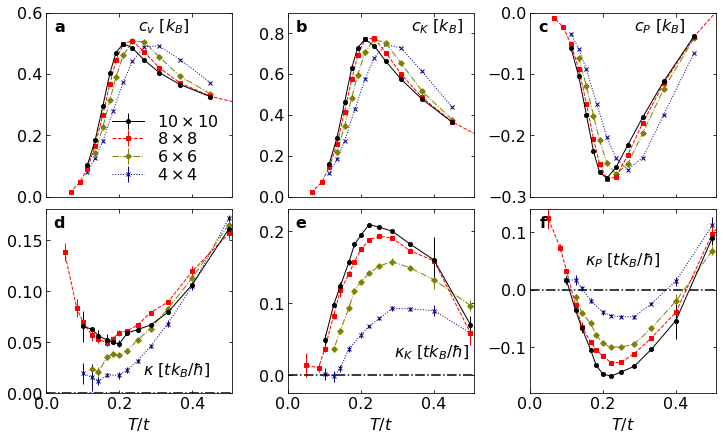

In [8]:
U=8
sitex = 8
sitey = 8
tp = 0


dt='05'

cmap = plt.cm.coolwarm
colorlist=['navy','olive','r','k']
symbols = ['x','D','s','o']
f, axs = plt.subplots(2,3, sharex='col', sharey=False, figsize=(12,7))
axs[0,0].tick_params(direction='in',bottom=True, top=True, left=True, right=True)
axs[0,1].tick_params(direction='in',bottom=True, top=True, left=True, right=True)
axs[0,2].tick_params(direction='in',bottom=True, top=True, left=True, right=True)
axs[1,0].tick_params(direction='in',bottom=True, top=True, left=True, right=True)
axs[1,1].tick_params(direction='in',bottom=True, top=True, left=True, right=True)
axs[1,2].tick_params(direction='in',bottom=True, top=True, left=True, right=True)

plt.subplots_adjust(wspace=0.3, hspace=0.07)
z0U8=None
zU8=None
axs[1,0].set_xlabel(r"$T/t$")
axs[1,1].set_xlabel(r"$T/t$")
axs[1,2].set_xlabel(r"$T/t$")


U=8
sitex = 4
sitey = 4
tp = 0

zU12=None
dt='05'

eks = np.load(f"../calculation/eks_{sitex:g}*{sitey:g}U{U:g}tp{tp:g}dt{dt}.npy")
eps = U*np.load(f"../calculation/eps_{sitex:g}*{sitey:g}U{U:g}tp{tp:g}dt{dt}.npy")
es = np.load(f"../calculation/es_{sitex:g}*{sitey:g}U{U:g}tp{tp:g}dt{dt}.npy")


xs,ys,yserror = derivative(1/betasU8_44[z0U8:zU8],es[0,z0U8:zU8,0],es[0,z0U8:zU8,1])
axs[0,0].errorbar(xs,ys,yserror,lw=1, ms=4,color=colorlist[0],marker=symbols[0], linestyle='dotted',label=rf'$4 \times 4$'
           )


xs,ys,yserror = derivative(1/betasU8_44[z0U8:zU8],eks[0,z0U8:zU8,0],eks[0,z0U8:zU8,1])
axs[0,1].errorbar(xs,ys,yserror,lw=1, ms=4,color=colorlist[0],marker=symbols[0], linestyle='dotted',label=rf'$4 \times 4$'
            #label='kinetic'
           )


xs,ys,yserror = derivative(1/betasU8_44[z0U8:zU8],eps[0,z0U8:zU8,0],eps[0,z0U8:zU8,1])
axs[0,2].errorbar(xs,ys,yserror,lw=1, ms=4,color=colorlist[0],marker=symbols[0], linestyle='dotted',label=rf'$4 \times 4$'
            #label='kinetic'
           )

axs[1,0].errorbar(1/betasU8_44[z0U8:zU8],kappasU8_44[z0U8:zU8,0],kappasU8_44[z0U8:zU8,1],lw=1, 
                  ms=4,color=colorlist[0],marker=symbols[0], linestyle='dotted'
            #label='kinetic'
           )


axs[1,1].errorbar(1/betasU8_44[z0U8:zU8],kappa1sU8_44[z0U8:zU8,0],kappa1sU8_44[z0U8:zU8,1],lw=1, 
                  ms=4,color=colorlist[0],marker=symbols[0], linestyle='dotted'
            #label='kinetic'
           )


axs[1,2].errorbar(1/betasU8_44[z0U8:zU8],kappa2sU8_44[z0U8:zU8,0],kappa2sU8_44[z0U8:zU8,1],lw=1, 
                  ms=4,color=colorlist[0],marker=symbols[0], linestyle='dotted'
            #label='kinetic'
           )


U=8
sitex = 6
sitey = 6
tp = 0
zU8=None
dt='05'

eks = np.load(f"../calculation/eks_{sitex:g}*{sitey:g}U{U:g}tp{tp:g}dt{dt}.npy")
eps = U*np.load(f"../calculation/eps_{sitex:g}*{sitey:g}U{U:g}tp{tp:g}dt{dt}.npy")
es = np.load(f"../calculation/es_{sitex:g}*{sitey:g}U{U:g}tp{tp:g}dt{dt}.npy")

xs,ys,yserror = derivative(1/betasU8_66[z0U8:zU8],es[0,z0U8:zU8,0],es[0,z0U8:zU8,1])
axs[0,0].errorbar(xs,ys,yserror,lw=1, ms=4,color=colorlist[1],marker=symbols[1], linestyle='-.',label=rf'$6 \times 6$'
           )


xs,ys,yserror = derivative(1/betasU8_66[z0U8:zU8],eks[0,z0U8:zU8,0],eks[0,z0U8:zU8,1])
axs[0,1].errorbar(xs,ys,yserror,lw=1, ms=4,color=colorlist[1],marker=symbols[1], linestyle='-.',label=rf'$6 \times 6$'
            #label='kinetic'
           )


xs,ys,yserror = derivative(1/betasU8_66[z0U8:zU8],eps[0,z0U8:zU8,0],eps[0,z0U8:zU8,1])
axs[0,2].errorbar(xs,ys,yserror,lw=1, ms=4,color=colorlist[1],marker=symbols[1], linestyle='-.',label=rf'$6 \times 6$'
            #label='kinetic'
           )

axs[1,0].errorbar(1/betasU8_66[z0U8:zU8],kappasU8_66[z0U8:zU8,0],kappasU8_66[z0U8:zU8,1],lw=1, 
                  ms=4,color=colorlist[1],marker=symbols[1], linestyle='-.'
            #label='kinetic'
           )


axs[1,1].errorbar(1/betasU8_66[z0U8:zU8],kappa1sU8_66[z0U8:zU8,0],kappa1sU8_66[z0U8:zU8,1],lw=1, 
                  ms=4,color=colorlist[1],marker=symbols[1], linestyle='-.'
            #label='kinetic'
           )


axs[1,2].errorbar(1/betasU8_66[z0U8:zU8],kappa2sU8_66[z0U8:zU8,0],kappa2sU8_66[z0U8:zU8,1],lw=1, 
                  ms=4,color=colorlist[1],marker=symbols[1], linestyle='-.'
            #label='kinetic'
           )



zU8=None
betas = betasU8
sitex = 8
sitey = 8

eks = np.load(f"../calculation/eks_{sitex:g}*{sitey:g}U{U:g}tp{tp:g}dt{dt}.npy")
eps = U*np.load(f"../calculation/eps_{sitex:g}*{sitey:g}U{U:g}tp{tp:g}dt{dt}.npy")
es = np.load(f"../calculation/es_{sitex:g}*{sitey:g}U{U:g}tp{tp:g}dt{dt}.npy")

k=0
z=None
z2=None
xs,ys,yserror = derivative(1/betas[z0U8:],es[0,z0U8:,0],es[0,z0U8:,1])
axs[0,0].errorbar(xs,ys,yserror,lw=1, ms=4,color=colorlist[2],marker=symbols[2], linestyle='dashed',label=rf'$8 \times 8$'
           )


xs,ys,yserror = derivative(1/betas[z0U8:],eks[0,z0U8:,0],eks[0,z0U8:,1])
axs[0,1].errorbar(xs,ys,yserror,lw=1, ms=4,color=colorlist[2],marker=symbols[2], linestyle='dashed',label=rf'$8 \times 8$'
            #label='kinetic'
           )


xs,ys,yserror = derivative(1/betas[z0U8:],eps[0,z0U8:,0],eps[0,z0U8:,1])
axs[0,2].errorbar(xs,ys,yserror,lw=1, ms=4,color=colorlist[2],marker=symbols[2], linestyle='dashed',label=rf'$8 \times 8$'
            #label='kinetic'
           )




axs[1,0].errorbar(1/betas[z0U8:zU8],kappasU8[z0U8:zU8,0],kappasU8[z0U8:zU8,1],lw=1, 
                  ms=4,color=colorlist[2],marker=symbols[2], linestyle='dashed'
            #label='kinetic'
           )


axs[1,1].errorbar(1/betas[z0U8:zU8],kappa1sU8[z0U8:zU8,0],kappa1sU8[z0U8:zU8,1],lw=1, 
                  ms=4,color=colorlist[2],marker=symbols[2], linestyle='dashed'
            #label='kinetic'
           )


axs[1,2].errorbar(1/betas[z0U8:zU8],kappa2sU8[z0U8:zU8,0],kappa2sU8[z0U8:zU8,1],lw=1, 
                  ms=4,color=colorlist[2],marker=symbols[2], linestyle='dashed'
            #label='kinetic'
           )




U=8
sitex = 10
sitey = 10
tp = 0
zU8=None
dt='05'

eks = np.load(f"../calculation/eks_{sitex:g}*{sitey:g}U{U:g}tp{tp:g}dt{dt}.npy")
eps = U*np.load(f"../calculation/eps_{sitex:g}*{sitey:g}U{U:g}tp{tp:g}dt{dt}.npy")
es = np.load(f"../calculation/es_{sitex:g}*{sitey:g}U{U:g}tp{tp:g}dt{dt}.npy")

xs,ys,yserror = derivative(1/betasU8_1010[z0U8:zU8],es[0,z0U8:zU8,0],es[0,z0U8:zU8,1])
axs[0,0].errorbar(xs,ys,yserror,lw=1, ms=4,color=colorlist[3],marker=symbols[3], linestyle='solid',label=rf'$10 \times 10$'
           )


xs,ys,yserror = derivative(1/betasU8_1010[z0U8:zU8],eks[0,z0U8:zU8,0],eks[0,z0U8:zU8,1])
axs[0,1].errorbar(xs,ys,yserror,lw=1, ms=4,color=colorlist[3],marker=symbols[3], linestyle='solid',label=rf'$10 \times 10$'
            #label='kinetic'
           )


xs,ys,yserror = derivative(1/betasU8_1010[z0U8:zU8],eps[0,z0U8:zU8,0],eps[0,z0U8:zU8,1])
axs[0,2].errorbar(xs,ys,yserror,lw=1, ms=4,color=colorlist[3],marker=symbols[3], linestyle='solid',label=rf'$10 \times 10$'
            #label='kinetic'
           )

axs[1,0].errorbar(1/betasU8_1010[z0U8:zU8],kappasU8_1010[z0U8:zU8,0],kappasU8_1010[z0U8:zU8,1],lw=1, 
                  ms=4,color=colorlist[3],marker=symbols[3], linestyle='solid'
            #label='kinetic'
           )


axs[1,1].errorbar(1/betasU8_1010[z0U8:zU8],kappa1sU8_1010[z0U8:zU8,0],kappa1sU8_1010[z0U8:zU8,1],lw=1, 
                  ms=4,color=colorlist[3],marker=symbols[3], linestyle='solid'
            #label='kinetic'
           )


axs[1,2].errorbar(1/betasU8_1010[z0U8:zU8],kappa2sU8_1010[z0U8:zU8,0],kappa2sU8_1010[z0U8:zU8,1],lw=1, 
                  ms=4,color=colorlist[3],marker=symbols[3], linestyle='solid'
            #label='kinetic'
           )



handles, labels = axs[0,0].get_legend_handles_labels()
axs[0,0].legend(handles[::-1], labels[::-1],frameon=False,labelspacing=0.1,fontsize=16,loc='lower right')   



  
axs[0,0].set_xlim(0,0.51)
axs[0,1].set_xlim(0,0.51)
axs[0,2].set_xlim(0,0.51)

axs[0,0].set_ylim(0,0.6)
axs[0,1].set_ylim(0,0.9)
axs[0,2].set_ylim(-0.3,0)

axs[1,0].set_ylim(0,0.18)
axs[1,1].set_ylim(-0.025,0.23)
axs[1,2].set_ylim(-0.18,0.14)

 
axs[1,0].axhline(0,linestyle='dashdot',color='k')  
axs[1,1].axhline(0,linestyle='dashdot',color='k')  
axs[1,2].axhline(0,linestyle='dashdot',color='k')  

axs[0,0].text(0.63,0.9,r"$c_v$ $[k_B]$", size=16, horizontalalignment='center',transform=axs[0,0].transAxes)
axs[0,1].text(0.8,0.9,r"$c_K$ $[k_B]$", size=16, horizontalalignment='center',transform=axs[0,1].transAxes)
axs[0,2].text(0.7,0.9,r"$c_P$ $[k_B]$", size=16, horizontalalignment='center',transform=axs[0,2].transAxes)
axs[1,0].text(0.7,0.1,r"$\kappa$ [$tk_B/\hbar$]", size=16, horizontalalignment='center',transform=axs[1,0].transAxes)
axs[1,1].text(0.77,0.2,r"$\kappa_K$ [$tk_B/\hbar$]", size=16, horizontalalignment='center',transform=axs[1,1].transAxes)
axs[1,2].text(0.5,0.7,r"$\kappa_P$ [$tk_B/\hbar$]", size=16, horizontalalignment='center',transform=axs[1,2].transAxes)

axs[0,0].text(0.07,0.9,"a", size=16, weight='bold',horizontalalignment='center',transform=axs[0,0].transAxes)
axs[0,1].text(0.07,0.9,"b", size=16, weight='bold',horizontalalignment='center',transform=axs[0,1].transAxes)
axs[0,2].text(0.07,0.9,"c", size=16, weight='bold',horizontalalignment='center',transform=axs[0,2].transAxes)
axs[1,0].text(0.07,0.9,"d", size=16, weight='bold',horizontalalignment='center',transform=axs[1,0].transAxes)
axs[1,1].text(0.07,0.9,"e", size=16, weight='bold',horizontalalignment='center',transform=axs[1,1].transAxes)
axs[1,2].text(0.07,0.9,"f", size=16, weight='bold',horizontalalignment='center',transform=axs[1,2].transAxes)
plt.savefig("plots/fig_finitesize_U8.pdf",bbox_inches = 'tight',pad_inches=0.02,dpi=1000)
plt.show()

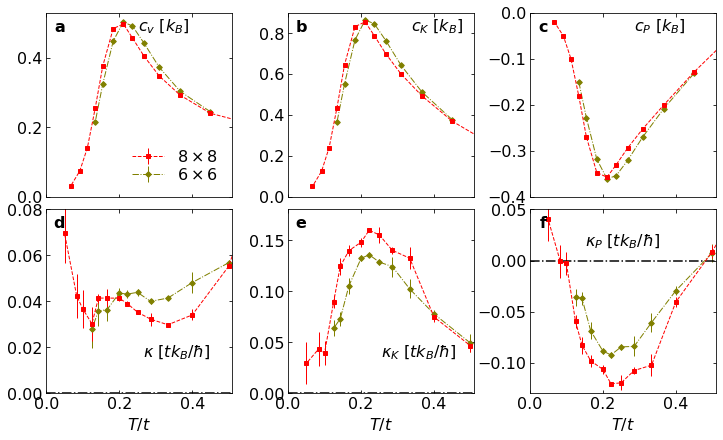

In [9]:
U=10
sitex = 8
sitey = 8
tp = 0


dt='05'

cmap = plt.cm.coolwarm
colorlist=['navy','olive','r','k']
symbols = ['x','D','s','o']
f, axs = plt.subplots(2,3, sharex='col', sharey=False, figsize=(12,7))
axs[0,0].tick_params(direction='in',bottom=True, top=True, left=True, right=True)
axs[0,1].tick_params(direction='in',bottom=True, top=True, left=True, right=True)
axs[0,2].tick_params(direction='in',bottom=True, top=True, left=True, right=True)
axs[1,0].tick_params(direction='in',bottom=True, top=True, left=True, right=True)
axs[1,1].tick_params(direction='in',bottom=True, top=True, left=True, right=True)
axs[1,2].tick_params(direction='in',bottom=True, top=True, left=True, right=True)

plt.subplots_adjust(wspace=0.3, hspace=0.07)
z0U10=None
zU10=None
axs[1,0].set_xlabel(r"$T/t$")
axs[1,1].set_xlabel(r"$T/t$")
axs[1,2].set_xlabel(r"$T/t$")


U=10
sitex = 6
sitey = 6
tp = 0
zU10=None
dt='05'

eks = np.load(f"../calculation/eks_{sitex:g}*{sitey:g}U{U:g}tp{tp:g}dt{dt}.npy")
eps = U*np.load(f"../calculation/eps_{sitex:g}*{sitey:g}U{U:g}tp{tp:g}dt{dt}.npy")
es = np.load(f"../calculation/es_{sitex:g}*{sitey:g}U{U:g}tp{tp:g}dt{dt}.npy")

xs,ys,yserror = derivative(1/betasU10_66[z0U10:zU10],es[0,z0U10:zU10,0],es[0,z0U10:zU10,1])
axs[0,0].errorbar(xs,ys,yserror,lw=1, ms=4,color=colorlist[1],marker=symbols[1], linestyle='-.',label=rf'$6 \times 6$'
           )


xs,ys,yserror = derivative(1/betasU10_66[z0U10:zU10],eks[0,z0U10:zU10,0],eks[0,z0U10:zU10,1])
axs[0,1].errorbar(xs,ys,yserror,lw=1, ms=4,color=colorlist[1],marker=symbols[1], linestyle='-.',label=rf'$6 \times 6$'
            #label='kinetic'
           )


xs,ys,yserror = derivative(1/betasU10_66[z0U10:zU10],eps[0,z0U10:zU10,0],eps[0,z0U10:zU10,1])
axs[0,2].errorbar(xs,ys,yserror,lw=1, ms=4,color=colorlist[1],marker=symbols[1], linestyle='-.',label=rf'$6 \times 6$'
            #label='kinetic'
           )

axs[1,0].errorbar(1/betasU10_66[z0U10:zU10],kappasU10_66[z0U10:zU10,0],kappasU10_66[z0U10:zU10,1],lw=1, 
                  ms=4,color=colorlist[1],marker=symbols[1], linestyle='-.'
            #label='kinetic'
           )


axs[1,1].errorbar(1/betasU10_66[z0U10:zU10],kappa1sU10_66[z0U10:zU10,0],kappa1sU10_66[z0U10:zU10,1],lw=1, 
                  ms=4,color=colorlist[1],marker=symbols[1], linestyle='-.'
            #label='kinetic'
           )


axs[1,2].errorbar(1/betasU10_66[z0U10:zU10],kappa2sU10_66[z0U10:zU10,0],kappa2sU10_66[z0U10:zU10,1],lw=1, 
                  ms=4,color=colorlist[1],marker=symbols[1], linestyle='-.'
            #label='kinetic'
           )



zU10=None
betas = betasU10
sitex = 8
sitey = 8

eks = np.load(f"../calculation/eks_{sitex:g}*{sitey:g}U{U:g}tp{tp:g}dt{dt}.npy")
eps = U*np.load(f"../calculation/eps_{sitex:g}*{sitey:g}U{U:g}tp{tp:g}dt{dt}.npy")
es = np.load(f"../calculation/es_{sitex:g}*{sitey:g}U{U:g}tp{tp:g}dt{dt}.npy")

k=0
z=None
z2=None
xs,ys,yserror = derivative(1/betas[z0U10:],es[0,z0U10:,0],es[0,z0U10:,1])
axs[0,0].errorbar(xs,ys,yserror,lw=1, ms=4,color=colorlist[2],marker=symbols[2], linestyle='dashed',label=rf'$8 \times 8$'
           )


xs,ys,yserror = derivative(1/betas[z0U10:],eks[0,z0U10:,0],eks[0,z0U10:,1])
axs[0,1].errorbar(xs,ys,yserror,lw=1, ms=4,color=colorlist[2],marker=symbols[2], linestyle='dashed',label=rf'$8 \times 8$'
            #label='kinetic'
           )


xs,ys,yserror = derivative(1/betas[z0U10:],eps[0,z0U10:,0],eps[0,z0U10:,1])
axs[0,2].errorbar(xs,ys,yserror,lw=1, ms=4,color=colorlist[2],marker=symbols[2], linestyle='dashed',label=rf'$8 \times 8$'
            #label='kinetic'
           )




axs[1,0].errorbar(1/betas[z0U10:zU10],kappasU10[z0U10:zU10,0],kappasU10[z0U10:zU10,1],lw=1, 
                  ms=4,color=colorlist[2],marker=symbols[2], linestyle='dashed'
            #label='kinetic'
           )


axs[1,1].errorbar(1/betas[z0U10:zU10],kappa1sU10[z0U10:zU10,0],kappa1sU10[z0U10:zU10,1],lw=1, 
                  ms=4,color=colorlist[2],marker=symbols[2], linestyle='dashed'
            #label='kinetic'
           )


axs[1,2].errorbar(1/betas[z0U10:zU10],kappa2sU10[z0U10:zU10,0],kappa2sU10[z0U10:zU10,1],lw=1, 
                  ms=4,color=colorlist[2],marker=symbols[2], linestyle='dashed'
            #label='kinetic'
           )

handles, labels = axs[0,0].get_legend_handles_labels()
axs[0,0].legend(handles[::-1], labels[::-1],frameon=False,labelspacing=0.1,fontsize=16,loc='lower right')   




  
axs[0,0].set_xlim(0,0.51)
axs[0,1].set_xlim(0,0.51)
axs[0,2].set_xlim(0,0.51)

axs[0,0].set_ylim(0,0.53)
axs[0,1].set_ylim(0,0.9)
axs[0,2].set_ylim(-0.4,0)

axs[1,0].set_ylim(0,0.08)
axs[1,1].set_ylim(0,0.18)
axs[1,2].set_ylim(-0.13,0.05)

 
axs[1,0].axhline(0,linestyle='dashdot',color='k')  
axs[1,1].axhline(0,linestyle='dashdot',color='k')  
axs[1,2].axhline(0,linestyle='dashdot',color='k')  

axs[0,0].text(0.63,0.9,r"$c_v$ $[k_B]$", size=16, horizontalalignment='center',transform=axs[0,0].transAxes)
axs[0,1].text(0.8,0.9,r"$c_K$ $[k_B]$", size=16, horizontalalignment='center',transform=axs[0,1].transAxes)
axs[0,2].text(0.7,0.9,r"$c_P$ $[k_B]$", size=16, horizontalalignment='center',transform=axs[0,2].transAxes)
axs[1,0].text(0.7,0.2,r"$\kappa$ [$tk_B/\hbar$]", size=16, horizontalalignment='center',transform=axs[1,0].transAxes)
axs[1,1].text(0.7,0.2,r"$\kappa_K$ [$tk_B/\hbar$]", size=16, horizontalalignment='center',transform=axs[1,1].transAxes)
axs[1,2].text(0.5,0.8,r"$\kappa_P$ [$tk_B/\hbar$]", size=16, horizontalalignment='center',transform=axs[1,2].transAxes)

axs[0,0].text(0.07,0.9,"a", size=16, weight='bold',horizontalalignment='center',transform=axs[0,0].transAxes)
axs[0,1].text(0.07,0.9,"b", size=16, weight='bold',horizontalalignment='center',transform=axs[0,1].transAxes)
axs[0,2].text(0.07,0.9,"c", size=16, weight='bold',horizontalalignment='center',transform=axs[0,2].transAxes)
axs[1,0].text(0.07,0.9,"d", size=16, weight='bold',horizontalalignment='center',transform=axs[1,0].transAxes)
axs[1,1].text(0.07,0.9,"e", size=16, weight='bold',horizontalalignment='center',transform=axs[1,1].transAxes)
axs[1,2].text(0.07,0.9,"f", size=16, weight='bold',horizontalalignment='center',transform=axs[1,2].transAxes)
plt.savefig("plots/fig_finitesize_U10.pdf",bbox_inches = 'tight',pad_inches=0.02,dpi=1000)
plt.show()

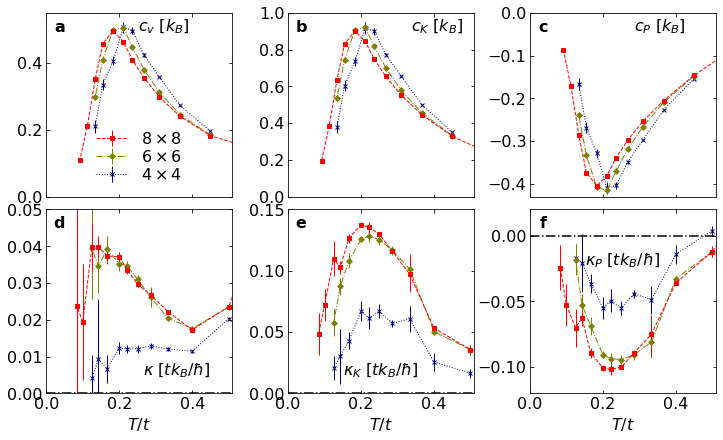

In [10]:
U=12
sitex = 8
sitey = 8
tp = 0


dt='05'

cmap = plt.cm.coolwarm
colorlist=['navy','olive','r','k']
symbols = ['x','D','s','o']
f, axs = plt.subplots(2,3, sharex='col', sharey=False, figsize=(12,7))
axs[0,0].tick_params(direction='in',bottom=True, top=True, left=True, right=True)
axs[0,1].tick_params(direction='in',bottom=True, top=True, left=True, right=True)
axs[0,2].tick_params(direction='in',bottom=True, top=True, left=True, right=True)
axs[1,0].tick_params(direction='in',bottom=True, top=True, left=True, right=True)
axs[1,1].tick_params(direction='in',bottom=True, top=True, left=True, right=True)
axs[1,2].tick_params(direction='in',bottom=True, top=True, left=True, right=True)

plt.subplots_adjust(wspace=0.3, hspace=0.07)
z0U12=None
zU12=None
axs[1,0].set_xlabel(r"$T/t$")
axs[1,1].set_xlabel(r"$T/t$")
axs[1,2].set_xlabel(r"$T/t$")


U=12
sitex = 4
sitey = 4
tp = 0

zU12=None
dt='05'

eks = np.load(f"../calculation/eks_{sitex:g}*{sitey:g}U{U:g}tp{tp:g}dt{dt}.npy")
eps = U*np.load(f"../calculation/eps_{sitex:g}*{sitey:g}U{U:g}tp{tp:g}dt{dt}.npy")
es = np.load(f"../calculation/es_{sitex:g}*{sitey:g}U{U:g}tp{tp:g}dt{dt}.npy")


xs,ys,yserror = derivative(1/betasU12_44[z0U12:zU12],es[0,z0U12:zU12,0],es[0,z0U12:zU12,1])
axs[0,0].errorbar(xs,ys,yserror,lw=1, ms=4,color=colorlist[0],marker=symbols[0], linestyle='dotted',label=rf'$4 \times 4$'
           )


xs,ys,yserror = derivative(1/betasU12_44[z0U12:zU12],eks[0,z0U12:zU12,0],eks[0,z0U12:zU12,1])
axs[0,1].errorbar(xs,ys,yserror,lw=1, ms=4,color=colorlist[0],marker=symbols[0], linestyle='dotted',label=rf'$4 \times 4$'
            #label='kinetic'
           )


xs,ys,yserror = derivative(1/betasU12_44[z0U12:zU12],eps[0,z0U12:zU12,0],eps[0,z0U12:zU12,1])
axs[0,2].errorbar(xs,ys,yserror,lw=1, ms=4,color=colorlist[0],marker=symbols[0], linestyle='dotted',label=rf'$4 \times 4$'
            #label='kinetic'
           )

axs[1,0].errorbar(1/betasU12_44[z0U12:zU12],kappasU12_44[z0U12:zU12,0],kappasU12_44[z0U12:zU12,1],lw=1, 
                  ms=4,color=colorlist[0],marker=symbols[0], linestyle='dotted'
            #label='kinetic'
           )


axs[1,1].errorbar(1/betasU12_44[z0U12:zU12],kappa1sU12_44[z0U12:zU12,0],kappa1sU12_44[z0U12:zU12,1],lw=1, 
                  ms=4,color=colorlist[0],marker=symbols[0], linestyle='dotted'
            #label='kinetic'
           )


axs[1,2].errorbar(1/betasU12_44[z0U12:zU12],kappa2sU12_44[z0U12:zU12,0],kappa2sU12_44[z0U12:zU12,1],lw=1, 
                  ms=4,color=colorlist[0],marker=symbols[0], linestyle='dotted'
            #label='kinetic'
           )


U=12
sitex = 6
sitey = 6
tp = 0
zU12=None
dt='05'

eks = np.load(f"../calculation/eks_{sitex:g}*{sitey:g}U{U:g}tp{tp:g}dt{dt}.npy")
eps = U*np.load(f"../calculation/eps_{sitex:g}*{sitey:g}U{U:g}tp{tp:g}dt{dt}.npy")
es = np.load(f"../calculation/es_{sitex:g}*{sitey:g}U{U:g}tp{tp:g}dt{dt}.npy")

xs,ys,yserror = derivative(1/betasU12_66[z0U12:zU12],es[0,z0U12:zU12,0],es[0,z0U12:zU12,1])
axs[0,0].errorbar(xs,ys,yserror,lw=1, ms=4,color=colorlist[1],marker=symbols[1], linestyle='-.',label=rf'$6 \times 6$'
           )


xs,ys,yserror = derivative(1/betasU12_66[z0U12:zU12],eks[0,z0U12:zU12,0],eks[0,z0U12:zU12,1])
axs[0,1].errorbar(xs,ys,yserror,lw=1, ms=4,color=colorlist[1],marker=symbols[1], linestyle='-.',label=rf'$6 \times 6$'
            #label='kinetic'
           )


xs,ys,yserror = derivative(1/betasU12_66[z0U12:zU12],eps[0,z0U12:zU12,0],eps[0,z0U12:zU12,1])
axs[0,2].errorbar(xs,ys,yserror,lw=1, ms=4,color=colorlist[1],marker=symbols[1], linestyle='-.',label=rf'$6 \times 6$'
            #label='kinetic'
           )

axs[1,0].errorbar(1/betasU12_66[z0U12:zU12],kappasU12_66[z0U12:zU12,0],kappasU12_66[z0U12:zU12,1],lw=1, 
                  ms=4,color=colorlist[1],marker=symbols[1], linestyle='-.'
            #label='kinetic'
           )


axs[1,1].errorbar(1/betasU12_66[z0U12:zU12],kappa1sU12_66[z0U12:zU12,0],kappa1sU12_66[z0U12:zU12,1],lw=1, 
                  ms=4,color=colorlist[1],marker=symbols[1], linestyle='-.'
            #label='kinetic'
           )


axs[1,2].errorbar(1/betasU12_66[z0U12:zU12],kappa2sU12_66[z0U12:zU12,0],kappa2sU12_66[z0U12:zU12,1],lw=1, 
                  ms=4,color=colorlist[1],marker=symbols[1], linestyle='-.'
            #label='kinetic'
           )



zU12=None
betas = betasU12
sitex = 8
sitey = 8

eks = np.load(f"../calculation/eks_{sitex:g}*{sitey:g}U{U:g}tp{tp:g}dt{dt}.npy")
eps = U*np.load(f"../calculation/eps_{sitex:g}*{sitey:g}U{U:g}tp{tp:g}dt{dt}.npy")
es = np.load(f"../calculation/es_{sitex:g}*{sitey:g}U{U:g}tp{tp:g}dt{dt}.npy")

k=0
z=None
z2=None
xs,ys,yserror = derivative(1/betas[z0U12:],es[0,z0U12:,0],es[0,z0U12:,1])
axs[0,0].errorbar(xs,ys,yserror,lw=1, ms=4,color=colorlist[2],marker=symbols[2], linestyle='dashed',label=rf'$8 \times 8$'
           )


xs,ys,yserror = derivative(1/betas[z0U12:],eks[0,z0U12:,0],eks[0,z0U12:,1])
axs[0,1].errorbar(xs,ys,yserror,lw=1, ms=4,color=colorlist[2],marker=symbols[2], linestyle='dashed',label=rf'$8 \times 8$'
            #label='kinetic'
           )


xs,ys,yserror = derivative(1/betas[z0U12:],eps[0,z0U12:,0],eps[0,z0U12:,1])
axs[0,2].errorbar(xs,ys,yserror,lw=1, ms=4,color=colorlist[2],marker=symbols[2], linestyle='dashed',label=rf'$8 \times 8$'
            #label='kinetic'
           )




axs[1,0].errorbar(1/betas[z0U12:zU12],kappasU12[z0U12:zU12,0],kappasU12[z0U12:zU12,1],lw=1, 
                  ms=4,color=colorlist[2],marker=symbols[2], linestyle='dashed'
            #label='kinetic'
           )


axs[1,1].errorbar(1/betas[z0U12:zU12],kappa1sU12[z0U12:zU12,0],kappa1sU12[z0U12:zU12,1],lw=1, 
                  ms=4,color=colorlist[2],marker=symbols[2], linestyle='dashed'
            #label='kinetic'
           )


axs[1,2].errorbar(1/betas[z0U12:zU12],kappa2sU12[z0U12:zU12,0],kappa2sU12[z0U12:zU12,1],lw=1, 
                  ms=4,color=colorlist[2],marker=symbols[2], linestyle='dashed'
            #label='kinetic'
           )

handles, labels = axs[0,0].get_legend_handles_labels()
axs[0,0].legend(handles[::-1], labels[::-1],frameon=False,labelspacing=0.1,fontsize=16,loc='lower center')   



  
axs[0,0].set_xlim(0,0.51)
axs[0,1].set_xlim(0,0.51)
axs[0,2].set_xlim(0,0.51)

axs[0,0].set_ylim(0,0.55)
axs[0,1].set_ylim(0,1)
axs[0,2].set_ylim(-0.43,0)

axs[1,0].set_ylim(0,0.05)
axs[1,1].set_ylim(0,0.15)
axs[1,2].set_ylim(-0.12,0.02)

 
axs[1,0].axhline(0,linestyle='dashdot',color='k')  
axs[1,1].axhline(0,linestyle='dashdot',color='k')  
axs[1,2].axhline(0,linestyle='dashdot',color='k')  

axs[0,0].text(0.63,0.9,r"$c_v$ $[k_B]$", size=16, horizontalalignment='center',transform=axs[0,0].transAxes)
axs[0,1].text(0.8,0.9,r"$c_K$ $[k_B]$", size=16, horizontalalignment='center',transform=axs[0,1].transAxes)
axs[0,2].text(0.7,0.9,r"$c_P$ $[k_B]$", size=16, horizontalalignment='center',transform=axs[0,2].transAxes)
axs[1,0].text(0.7,0.1,r"$\kappa$ [$tk_B/\hbar$]", size=16, horizontalalignment='center',transform=axs[1,0].transAxes)
axs[1,1].text(0.5,0.1,r"$\kappa_K$ [$tk_B/\hbar$]", size=16, horizontalalignment='center',transform=axs[1,1].transAxes)
axs[1,2].text(0.5,0.7,r"$\kappa_P$ [$tk_B/\hbar$]", size=16, horizontalalignment='center',transform=axs[1,2].transAxes)

axs[0,0].text(0.07,0.9,"a", size=16, weight='bold',horizontalalignment='center',transform=axs[0,0].transAxes)
axs[0,1].text(0.07,0.9,"b", size=16, weight='bold',horizontalalignment='center',transform=axs[0,1].transAxes)
axs[0,2].text(0.07,0.9,"c", size=16, weight='bold',horizontalalignment='center',transform=axs[0,2].transAxes)
axs[1,0].text(0.07,0.9,"d", size=16, weight='bold',horizontalalignment='center',transform=axs[1,0].transAxes)
axs[1,1].text(0.07,0.9,"e", size=16, weight='bold',horizontalalignment='center',transform=axs[1,1].transAxes)
axs[1,2].text(0.07,0.9,"f", size=16, weight='bold',horizontalalignment='center',transform=axs[1,2].transAxes)
plt.savefig("plots/fig_finitesize_U12.pdf",bbox_inches = 'tight',pad_inches=0.02,dpi=1000)
plt.show()

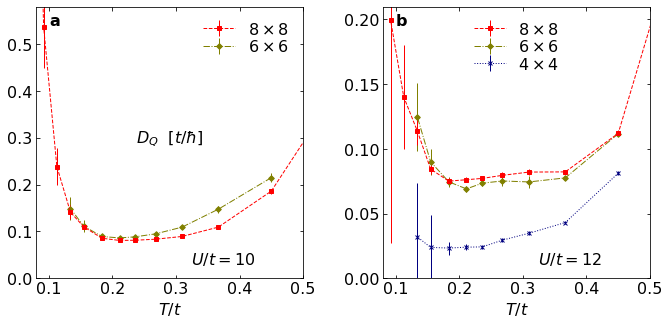

In [11]:
Us=np.array([10,12])
sitex = 8
sitey = 8
tp = 0

colorlist=['navy','olive','r','k']
dt='05'

cmap = plt.cm.coolwarm
f, axs = plt.subplots(1, 2, sharex=True, sharey=False, figsize=(11,5))
axs[0].tick_params(direction='in',bottom=True, top=True, left=True, right=True)
axs[1].tick_params(direction='in',bottom=True, top=True, left=True, right=True)

plt.subplots_adjust(wspace=0.3, hspace=0.08)
axs[0].set_xlabel(r"$T/t$")
axs[1].set_xlabel(r"$T/t$")


axs[0].set_xlim(0,0.5)

symbols = ['x','D','s','o']




 
z2=None
U=12
sitex = 4
sitey = 4
es = np.load(f"../calculation/es_{sitex:g}*{sitey:g}U{U:g}tp{tp:g}dt{dt}.npy")
xs,ys,yserror = derivative(1/betasU12_44,es[0,:,0],es[0,:,1])
z21=None
x1s,y1s,y1serror = mean(1/betasU12_44,kappasU12_44[:,0],kappasU12_44[:,1])
axs[1].errorbar(xs[:z2],
                 (y1s/ys)[:z2],
              yerr=(np.sqrt((y1serror/y1s)**2+(yserror/ys)**2)*(y1s/ys))[:z2],  
              lw=1, ms=4,color=colorlist[0],marker=symbols[0], linestyle='dotted',label=rf'$4\times 4$'
               )


   
z2=None
U=10
sitex = 6
sitey = 6
es = np.load(f"../calculation/es_{sitex:g}*{sitey:g}U{U:g}tp{tp:g}dt{dt}.npy")
xs,ys,yserror = derivative(1/betasU10_66,es[0,:,0],es[0,:,1])
z21=-3
x1s,y1s,y1serror = mean(1/betasU10_66,kappasU10_66[:,0],kappasU10_66[:,1])
axs[0].errorbar(xs[:z2],
                 (y1s/ys)[:z2],
              yerr=(np.sqrt((y1serror/y1s)**2+(yserror/ys)**2)*(y1s/ys))[:z2], 
              lw=1, ms=4,color=colorlist[1],marker=symbols[1], linestyle='-.',label=rf'$6\times 6$'
               )


z2=None
U=12
sitex = 6
sitey = 6
es = np.load(f"../calculation/es_{sitex:g}*{sitey:g}U{U:g}tp{tp:g}dt{dt}.npy")
xs,ys,yserror = derivative(1/betasU12_66,es[0,:,0],es[0,:,1])
z21=-3
x1s,y1s,y1serror = mean(1/betasU12_66,kappasU12_66[:,0],kappasU12_66[:,1])
axs[1].errorbar(xs[:z2],
                 (y1s/ys)[:z2],
              yerr=(np.sqrt((y1serror/y1s)**2+(yserror/ys)**2)*(y1s/ys))[:z2], 
              lw=1, ms=4,color=colorlist[1],marker=symbols[1], linestyle='-.',label=rf'$6\times 6$'
               )

sitex = 8
sitey = 8
for i,U in enumerate(Us):
    if U==10:
        betas = betasU10
        Ds= DsU10
        DQs = DQsU10
        kappas =kappasU10
        z2=None
        z20=-7
    elif U==12:
        betas = betasU12
        Ds= DsU12
        DQs = DQsU12
        kappas =kappasU12
        z2=None
        z20=-9
        
    es = np.load(f"../calculation/es_{sitex:g}*{sitey:g}U{U:g}tp{tp:g}dt{dt}.npy")
    xs,ys,yserror = derivative(1/betas,es[0,:,0],es[0,:,1])
    
    x1s,y1s,y1serror = mean(1/betas,kappas[:,0],kappas[:,1])
    axs[i].errorbar(xs[:z2],
                     (y1s/ys)[:z2],
                  yerr=(np.sqrt((y1serror/y1s)**2+(yserror/ys)**2)*(y1s/ys))[:z2], 
                  lw=1, ms=4,color=colorlist[2],marker=symbols[2], linestyle='dashed',label=rf'$8\times 8$'
                   )


    axs[i].text(0.7,0.05,rf"$U/t={U:g}$", size=16, horizontalalignment='center',transform=axs[i].transAxes)

   
for i,U in enumerate(Us):
    handles, labels = axs[i].get_legend_handles_labels()
    axs[i].legend(handles[::-1], labels[::-1],frameon=False,labelspacing=0.1,fontsize=16)


axs[0].text(0.5,0.5,r"$D_Q$  $[t/\hbar]$",size=16,horizontalalignment='center',transform=axs[0].transAxes)

axs[0].set_ylim(0,0.58)
axs[1].set_ylim(0,0.21)

axs[0].set_xlim(0.08,0.5)
axs[0].set_xticks([0.1,0.2,0.3,0.4,0.5])

axs[1].set_xlim(0.08,0.5)
axs[1].set_xticks([0.1,0.2,0.3,0.4,0.5])

axs[0].text(0.07,0.93,"a", size=16, weight='bold',horizontalalignment='center',transform=axs[0].transAxes)
axs[1].text(0.07,0.93,"b", size=16, weight='bold',horizontalalignment='center',transform=axs[1].transAxes)

plt.savefig("plots/fig_diffusivity_FF.pdf",bbox_inches = 'tight',pad_inches=0.02,dpi=1000)
plt.show()